# Mod 3 Project - Projecting if a Zip Code in the US has Above/Under 49,000 USD Median Income


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

## Importing and cleaning the data, merging Dataframes, EDA

In [2]:
df = pd.read_csv('data_sets/mod3p1.csv', encoding='latin-1')

In [3]:
#cheking the unique zip codes in the dataframe
print (len(df))
print (df['Zip_Code'].nunique())

32526
14803


In [4]:
#looking on example of duplication 
df.sort_values('Zip_Code',ascending=True).head(2)

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
32481,72026,72,Puerto Rico,PR,Adjuntas Municipio,Adjuntas,Adjuntas,Track,Track,601,787,42529236,210360,18.155582,-66.701046,24000,15004,29483,1243.880991
32519,7202946,72,Puerto Rico,PR,Adjuntas Municipio,Adjuntas,Adjuntas,Track,Track,601,787,44833906,90659,18.204166,-66.737830,19807,9378,21654,524.345149


In [5]:
#droping duplicates
df = df.drop_duplicates(subset='Zip_Code', keep='first')
len(df)

14803

In [6]:
#droping columns which are not relevant or with to big variaty of items
df = df.drop(['id','State_ab','Primary','Area_Code','Lat','Lon','County','State_Code','Place','sum_w','City'],axis = 1)

In [7]:
df.head(2)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev
0,Alabama,City,36611,10894952,909156,38773,30506,33101
1,Alabama,City,36048,26070325,23254,37725,19528,43789


In [8]:
#cheking the type of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14803 entries, 0 to 32483
Data columns (total 8 columns):
State_Name    14803 non-null object
Type          14803 non-null object
Zip_Code      14803 non-null int64
ALand         14803 non-null int64
AWater        14803 non-null int64
Mean          14803 non-null int64
Median        14803 non-null int64
Stdev         14803 non-null int64
dtypes: int64(6), object(2)
memory usage: 1.0+ MB


In [9]:
#importing additioanl table which include the population for every zip code
df1 = pd.read_csv('data_sets/pop-by-zip-code.csv')

In [10]:
df1.head(2)

,zip_code,y-2016
0,601,17800
1,602,39716


In [11]:
#checking the number of unique values
print (len(df1))
print (df1['zip_code'].nunique())

33120
33120


In [12]:
#checking how many poeple live in the US
df1['y-2016'].sum()

322072436

In [13]:
#renaming the columns before merging
df1 = df1.rename(index=str, columns={"zip_code": "Zip_Code",'y-2016':'Population'})
df1.head(1)

,Zip_Code,Population
0,601,17800


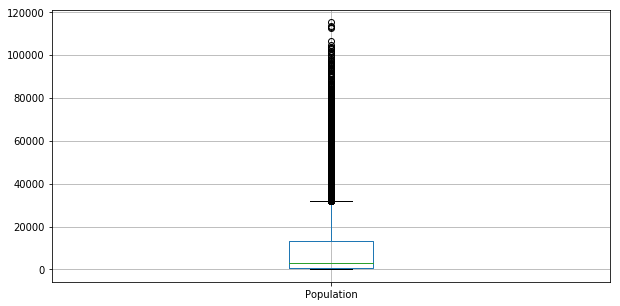

In [14]:
#cheking the population
plt.figure(figsize=(10, 5))
df1.boxplot(column=['Population'])
plt.show();

In [15]:
df1[df1['Population']<1000].count()


Zip_Code      10144
Population    10144
dtype: int64

In [16]:
# I decided to drop zip codes with less than 1000 poeple
df1 = df1[df1['Population']>1000]

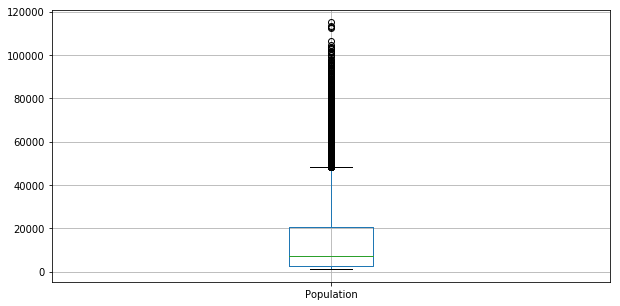

In [17]:
plt.figure(figsize=(10, 5))
df1.boxplot(column=['Population'])
plt.show();

In [18]:
#cheking that the merging column ("zip code") is integer like in the other dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22968 entries, 0 to 33119
Data columns (total 2 columns):
Zip_Code      22968 non-null int64
Population    22968 non-null int64
dtypes: int64(2)
memory usage: 538.3+ KB


In [19]:
#merging the dataframes
df3 = pd.merge(df, df1, on='Zip_Code', how='inner')

In [20]:
#inspecting the number of rows in the new merged DataFrame
len(df3)

13754

In [21]:
#cheking for null values
df3.isnull().sum()

State_Name    0
Type          0
Zip_Code      0
ALand         0
AWater        0
Mean          0
Median        0
Stdev         0
Population    0
dtype: int64

In [22]:
#import additioanl Dataframe with social security data
df4=pd.read_excel('data_sets/tableAll.xlsx')
df4.head(2)

,"Number of beneficiaries with benefits in current-payment status and total monthly benefits, December 2017",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,State or area,ZIP Code,Number,NaN,NaN,NaN,NaN,NaN,Total monthly benefits\n(thousands of dollars),NaN,NaN,Number of OASDI beneficiaries aged 65 or older
1,NaN,NaN,Total,Retired workers,Disabled workers,Widow(er)s and parents,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,NaN


In [23]:
#droping columns which are totals of other columns
df4 = df4.drop(['Unnamed: 2','Unnamed: 8'],axis = 1)

In [24]:
#updating values of cells which later will be columns
df4.at[1, 'Number of beneficiaries with benefits in current-payment status and total monthly benefits, December 2017'] = 'State or area'
df4.at[1, 'Unnamed: 1'] = 'Zip_Code'
df4.at[1, 'Unnamed: 11'] ='Number of OASDI beneficiaries aged 65 or older'
df4.at[1,'Unnamed: 3'] = 'Retired_workers_number'
df4.at[1,'Unnamed: 5'] = 'Widow(er)s_and_parents_number'

In [25]:
#checking the update
df4.head(2)

,"Number of beneficiaries with benefits in current-payment status and total monthly benefits, December 2017",Unnamed: 1,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,State or area,ZIP Code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Number of OASDI beneficiaries aged 65 or older
1,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older


In [26]:
#replacing the columns names with the values of line number 1
df4.columns = df4.iloc[1].values
df4.head(2)

,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
0,State or area,ZIP Code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Number of OASDI beneficiaries aged 65 or older
1,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older


In [27]:
#droping the first two lines
df4 = df4.drop([0, 1])
df4.head(1)

,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
2,Alabama,35004,1410,385,160,70,210,2070,218,1510


In [28]:
#we are checking the type of columns in the list
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37327 entries, 2 to 37328
Data columns (total 10 columns):
State or area                                     37324 non-null object
Zip_Code                                          37320 non-null object
Retired_workers_number                            37320 non-null object
Disabled workers                                  37320 non-null object
Widow(er)s_and_parents_number                     37320 non-null object
Spouses                                           37320 non-null object
Children                                          37320 non-null object
Retired workers                                   37320 non-null object
Widow(er)s and parents                            37320 non-null object
Number of OASDI beneficiaries aged 65 or older    37320 non-null object
dtypes: object(10)
memory usage: 3.1+ MB


In [29]:
#droping column which exist also in other dataframes
df4 = df4.drop('State or area',axis =1)
df4.head(1)

,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
2,35004,1410,385,160,70,210,2070,218,1510


In [30]:
#looking for null values
df4.isnull().sum()

Zip_Code                                          7
Retired_workers_number                            7
Disabled workers                                  7
Widow(er)s_and_parents_number                     7
Spouses                                           7
Children                                          7
Retired workers                                   7
Widow(er)s and parents                            7
Number of OASDI beneficiaries aged 65 or older    7
dtype: int64

In [31]:
#dataframe is big so idecided to drop the null values
df4.dropna(axis='rows',inplace=True)
df4.isnull().sum()

Zip_Code                                          0
Retired_workers_number                            0
Disabled workers                                  0
Widow(er)s_and_parents_number                     0
Spouses                                           0
Children                                          0
Retired workers                                   0
Widow(er)s and parents                            0
Number of OASDI beneficiaries aged 65 or older    0
dtype: int64

In [32]:
#changing the strings to integer
for col in df4.columns:
    df4[col] = df4[col].astype(int)
    

In [33]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37320 entries, 2 to 37321
Data columns (total 9 columns):
Zip_Code                                          37320 non-null int64
Retired_workers_number                            37320 non-null int64
Disabled workers                                  37320 non-null int64
Widow(er)s_and_parents_number                     37320 non-null int64
Spouses                                           37320 non-null int64
Children                                          37320 non-null int64
Retired workers                                   37320 non-null int64
Widow(er)s and parents                            37320 non-null int64
Number of OASDI beneficiaries aged 65 or older    37320 non-null int64
dtypes: int64(9)
memory usage: 2.8 MB


In [34]:
df4.corr()

,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
Zip_Code,1.000000,-0.011399,-0.056829,-0.008655,0.032466,-0.029198,-0.018049,-0.007699,-0.010819
Retired_workers_number,-0.011399,1.000000,0.823089,0.946041,0.892991,0.824377,0.989924,0.961689,0.999088
Disabled workers,-0.056829,0.823089,1.000000,0.891936,0.720431,0.955947,0.766252,0.838595,0.822221
Widow(er)s_and_parents_number,-0.008655,0.946041,0.891936,1.000000,0.905113,0.888898,0.913930,0.983303,0.953183
Spouses,0.032466,0.892991,0.720431,0.905113,1.000000,0.753852,0.871829,0.895361,0.907647
Children,-0.029198,0.824377,0.955947,0.888898,0.753852,1.000000,0.775316,0.843401,0.825170
Retired workers,-0.018049,0.989924,0.766252,0.913930,0.871829,0.775316,1.000000,0.952623,0.988688
Widow(er)s and parents,-0.007699,0.961689,0.838595,0.983303,0.895361,0.843401,0.952623,1.000000,0.967595
Number of OASDI beneficiaries aged 65 or older,-0.010819,0.999088,0.822221,0.953183,0.907647,0.825170,0.988688,0.967595,1.000000


In [35]:
#droping rows with very high multicolinearity
df4 = df4.drop(['Retired workers', 'Widow(er)s and parents','Number of OASDI beneficiaries aged 65 or older'],axis = 1)

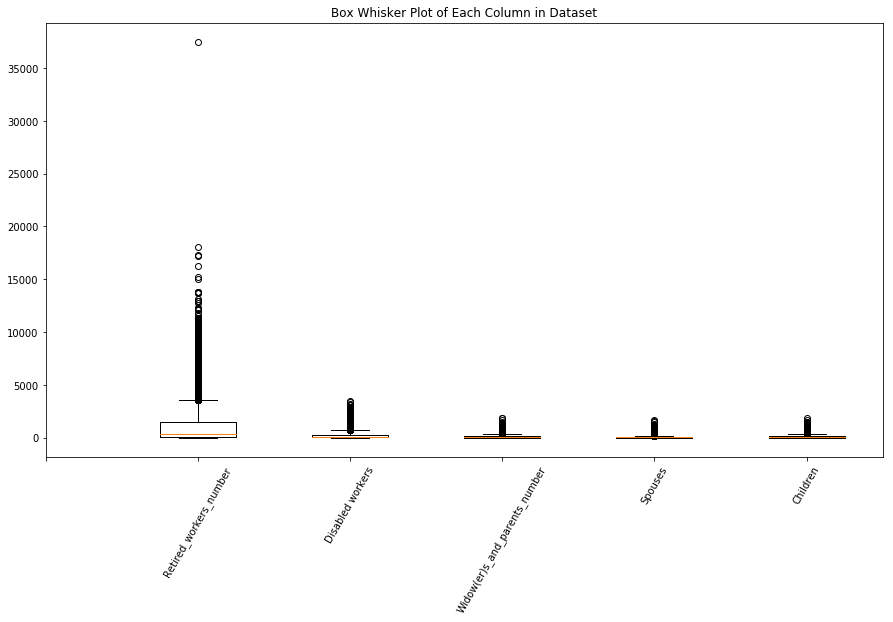

In [37]:
#looking how the data is spread
list_for_box = list(df4.columns.values)
list_for_box.pop(0)

# Create a Box Whisker Plot of each column
plt.figure(figsize=(15, 8))
plt.boxplot([df4[col] for col in df4.columns if col!='Zip_Code' ])
plt.title("Box Whisker Plot of Each Column in Dataset")
plt.xticks(range(len(df4.columns.values)), ['']+list_for_box, rotation=60)
plt.show()

In [38]:
#droping rows when some values equal to 0
for col in df4.columns:
    df4 = df4[df4[col] > 5]
    
len(df4)

24452

In [39]:
#merging with data frame with financial and geographical data
df5 = pd.merge(df3, df4, on='Zip_Code', how='inner')
df5.head(2)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children
0,Alabama,City,36611,10894952,909156,38773,30506,33101,5955,735,325,130,40,125
1,Alabama,City,36048,26070325,23254,37725,19528,43789,1430,310,125,40,10,50


In [40]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13528 entries, 0 to 13527
Data columns (total 14 columns):
State_Name                       13528 non-null object
Type                             13528 non-null object
Zip_Code                         13528 non-null int64
ALand                            13528 non-null int64
AWater                           13528 non-null int64
Mean                             13528 non-null int64
Median                           13528 non-null int64
Stdev                            13528 non-null int64
Population                       13528 non-null int64
Retired_workers_number           13528 non-null int64
Disabled workers                 13528 non-null int64
Widow(er)s_and_parents_number    13528 non-null int64
Spouses                          13528 non-null int64
Children                         13528 non-null int64
dtypes: int64(12), object(2)
memory usage: 1.5+ MB


In [41]:
#import one more dataframe to have also data about density in each zip code
df_denst = pd.read_csv('data_sets/uszips.csv')
df_denst.head(3)

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
0,601,18.1800,-66.7522,Adjuntas,PR,Puerto Rico,True,NaN,18570,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",False,False,America/Puerto_Rico
1,602,18.3607,-67.1752,Aguada,PR,Puerto Rico,True,NaN,41520,523.7,72003,Aguada,{'72003':100},False,False,America/Puerto_Rico
2,603,18.4544,-67.1220,Aguadilla,PR,Puerto Rico,True,NaN,54689,667.9,72005,Aguadilla,{'72005':100},False,False,America/Puerto_Rico


In [42]:
#keeping anly the zip code(for the merging) and the density
df_denst = df_denst[['zip','density']]
df_denst.head(2)

,zip,density
0,601,111.4
1,602,523.7


In [43]:
#renaming column in order to merge with df5
df_denst = df_denst.rename(index=str, columns={"zip": "Zip_Code"})

In [44]:
df_denst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33099 entries, 0 to 33098
Data columns (total 2 columns):
Zip_Code    33099 non-null int64
density     33099 non-null float64
dtypes: float64(1), int64(1)
memory usage: 775.8+ KB


In [45]:
#merging with df5
df5 = pd.merge(df5, df_denst, on='Zip_Code', how='inner')
df5.head(2)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,density
0,Alabama,City,36611,10894952,909156,38773,30506,33101,5955,735,325,130,40,125,496.2
1,Alabama,City,36048,26070325,23254,37725,19528,43789,1430,310,125,40,10,50,5.3


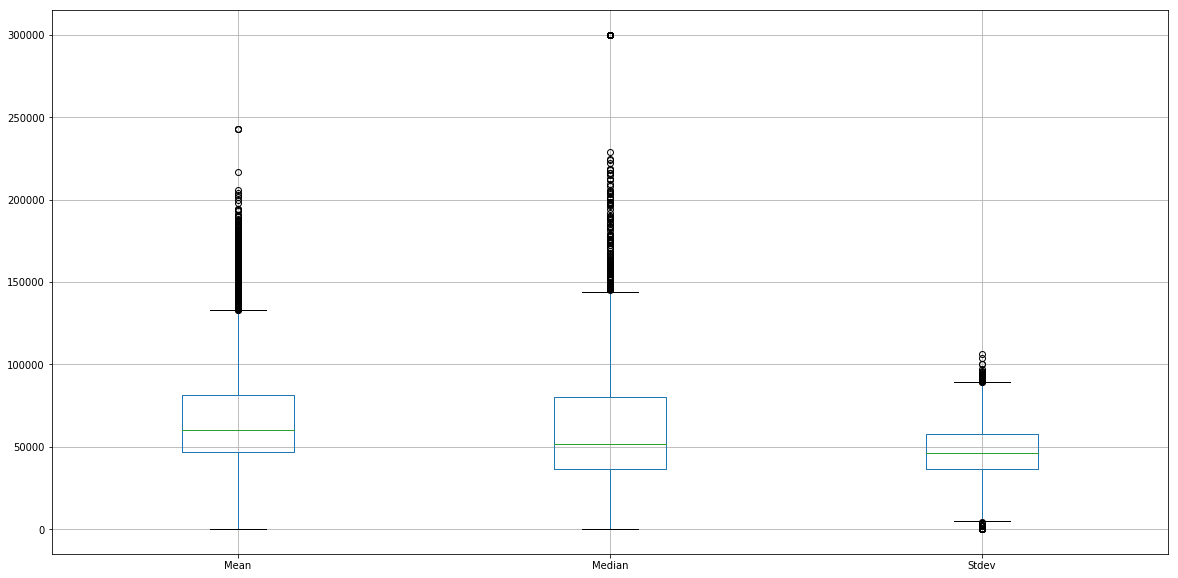

In [46]:
#inspecting median, average and standard deviation
plt.figure(figsize=(20, 10))
boxplot = df5.boxplot(column=['Mean', 'Median','Stdev'])
plt.show();

In [47]:
len(df5)

13528

In [48]:
#rease values of Median= 300,000 which are mistakes and zip codes with less than 1000 poeple
df5 = df5[df5.Median != 300000]
df5 = df5[df5.Median>1000]

In [49]:
len(df5)

11620

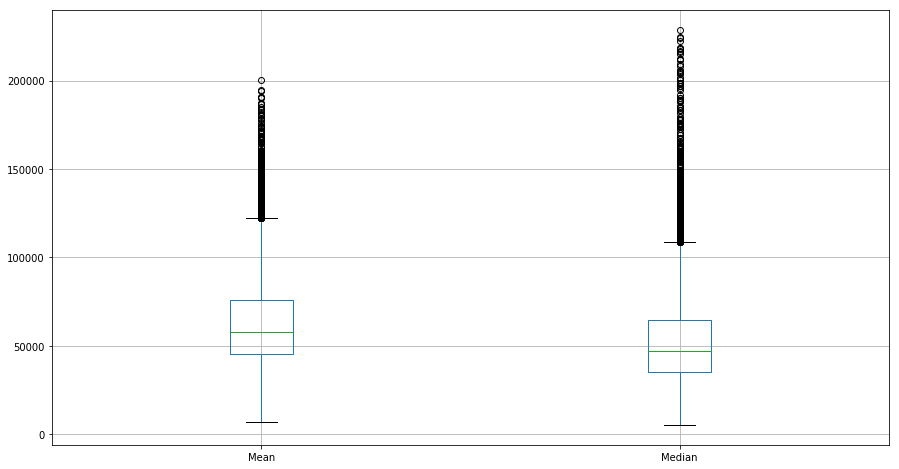

In [50]:
plt.figure(figsize=(12, 6))
boxplot = df5.boxplot(column=['Mean', 'Median'])
plt.show();

In [51]:
df5.head(2)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,density
0,Alabama,City,36611,10894952,909156,38773,30506,33101,5955,735,325,130,40,125,496.2
1,Alabama,City,36048,26070325,23254,37725,19528,43789,1430,310,125,40,10,50,5.3


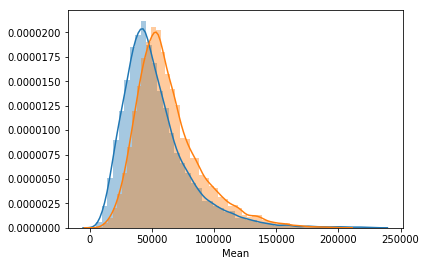

In [52]:
sns.distplot(df5['Median']);
sns.distplot(df5['Mean']);

Median and Mean distrinution is similar. I decided to work with the Median.

In [54]:
#Checking which kind of classifications the zip codes have
df5['Type'].value_counts()

Track           9548
City             807
CDP              543
Town             318
Village          284
Borough           95
Community         14
Urban              8
County             2
Municipality       1
Name: Type, dtype: int64

In [55]:
#assign values with small values counts to other similiar values
df5['Type'] = df5['Type'].replace(['Municipality', 'County'], 'Community')
df5['Type'] = df5['Type'].replace(['Urban'], 'City')

In [56]:
df5['Type'].value_counts()

Track        9548
City          815
CDP           543
Town          318
Village       284
Borough        95
Community      17
Name: Type, dtype: int64

In [57]:
#inspecting the data to define better the limit(over/under) for my terget value
df5.describe()

,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,density
count,11620.000000,1.162000e+04,1.162000e+04,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000
mean,48898.890103,1.217729e+08,3.073862e+06,63595.035112,53263.228227,46915.822375,19828.621429,2477.926850,525.301635,238.198795,140.240103,248.698795,902.856558
std,27908.066422,6.484929e+08,2.317899e+07,26564.874206,27592.104233,15098.199318,17026.341719,2007.081888,456.906433,189.034663,135.714308,215.206309,2526.763826
min,601.000000,6.909400e+04,0.000000e+00,6804.000000,5252.000000,5600.000000,1002.000000,35.000000,10.000000,10.000000,10.000000,10.000000,0.200000
25%,27842.750000,2.577235e+06,0.000000e+00,45446.000000,35094.750000,36358.750000,5828.000000,855.000000,175.000000,85.000000,45.000000,85.000000,27.100000
50%,46952.500000,8.634226e+06,7.824600e+04,57901.000000,47281.500000,45304.000000,15393.000000,1995.000000,400.000000,195.000000,100.000000,190.000000,143.700000
75%,73031.000000,7.130567e+07,8.814038e+05,76192.250000,64521.500000,56089.250000,29410.000000,3615.000000,750.000000,345.000000,195.000000,355.000000,967.475000
max,99926.000000,4.685105e+10,1.396368e+09,200012.000000,228723.000000,103836.000000,115104.000000,37440.000000,3490.000000,1895.000000,1645.000000,1825.000000,55636.000000


In [58]:
df5.corr()

,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,density
Zip_Code,1.000000,0.093387,0.032178,-0.043356,-0.040745,-0.044514,0.090920,0.010924,-0.076884,0.014172,0.078645,-0.032465,-0.095341
ALand,0.093387,1.000000,0.235712,-0.033061,-0.036589,-0.013141,-0.141413,-0.135646,-0.123368,-0.133146,-0.116303,-0.124639,-0.063469
AWater,0.032178,0.235712,1.000000,-0.001876,-0.008212,0.017212,-0.089957,-0.080468,-0.077442,-0.083171,-0.071131,-0.079468,-0.040525
Mean,-0.043356,-0.033061,-0.001876,1.000000,0.966368,0.866530,0.112485,0.130151,-0.213564,-0.014557,0.161611,-0.128807,0.061715
Median,-0.040745,-0.036589,-0.008212,0.966368,1.000000,0.745395,0.108220,0.120634,-0.201189,-0.013993,0.156108,-0.116764,0.045884
Stdev,-0.044514,-0.013141,0.017212,0.866530,0.745395,1.000000,0.087153,0.113521,-0.202200,-0.019135,0.138860,-0.139466,0.098155
Population,0.090920,-0.141413,-0.089957,0.112485,0.108220,0.087153,1.000000,0.837513,0.745716,0.827185,0.806333,0.807201,0.377862
Retired_workers_number,0.010924,-0.135646,-0.080468,0.130151,0.120634,0.113521,0.837513,1.000000,0.710973,0.906487,0.827059,0.721956,0.228234
Disabled workers,-0.076884,-0.123368,-0.077442,-0.213564,-0.201189,-0.202200,0.745716,0.710973,1.000000,0.825200,0.570766,0.940874,0.220768
Widow(er)s_and_parents_number,0.014172,-0.133146,-0.083171,-0.014557,-0.013993,-0.019135,0.827185,0.906487,0.825200,1.000000,0.851390,0.829357,0.193111


## Feature Engineering

In [59]:
#get dummies for the verbal features
df5 = pd.get_dummies(df5, columns=['Type'])
df5 = pd.get_dummies(df5, columns=['State_Name'])

In [60]:
#reset index in order to loop over the columns
df5.reset_index(drop=True, inplace = True)

In [61]:
df5.head(2)

,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,...,State_Name_South Dakota,State_Name_Tennessee,State_Name_Texas,State_Name_Utah,State_Name_Vermont,State_Name_Virginia,State_Name_Washington,State_Name_West Virginia,State_Name_Wisconsin,State_Name_Wyoming
0,36611,10894952,909156,38773,30506,33101,5955,735,325,130,...,0,0,0,0,0,0,0,0,0,0
1,36048,26070325,23254,37725,19528,43789,1430,310,125,40,...,0,0,0,0,0,0,0,0,0,0


In [62]:
#numpy is much faster than regular loop over the column. The number 49,000 was chosen to split around the half
df5['Median_Target'] = np.where(df5['Median']>49000,1,0)

In [63]:
df5.Median_Target.value_counts()

0    6167
1    5453
Name: Median_Target, dtype: int64

In [64]:
#seperating target from table
Target = df5['Median_Target']

In [65]:
#droping target and columns with too high correlation
df5 = df5.drop(["Zip_Code",'Median','Mean','Stdev','Median_Target'],axis=1)
df5.head(1)

,ALand,AWater,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,density,Type_Borough,...,State_Name_South Dakota,State_Name_Tennessee,State_Name_Texas,State_Name_Utah,State_Name_Vermont,State_Name_Virginia,State_Name_Washington,State_Name_West Virginia,State_Name_Wisconsin,State_Name_Wyoming
0,10894952,909156,5955,735,325,130,40,125,496.2,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
df5.shape

(11620, 68)

In [67]:
#running some test for logistic regression before starting feature ingineering
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df5, Target, test_size=0.2)
print(X_train_b.shape)
print(X_test_b.shape)
print(y_train_b.shape)
print(y_test_b.shape)

(9296, 68)
(2324, 68)
(9296,)
(2324,)


In [68]:
#creating function to print matrics results
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [111]:
#baseline logistic before feature ingineering
print('baseline Logistic')
print('-------------------')
lm = LogisticRegression()
lm.fit(X_train_b, y_train_b)
test_preds = lm.predict(X_test_b)
print_metrics(y_test_b, test_preds)

print('-------------------')
confusion = metrics.confusion_matrix(y_test_b, test_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

baseline Logistic
-------------------
Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.5172117039586919
F1 Score: 0.0
-------------------
True Positives: 0
True Negatives: 1202
False Positives: 0
False Negatives: 1122


In [70]:
#create polynomial features and interaction terms
poly = PolynomialFeatures(degree=2)
poly.fit(df5)
column_names = poly.get_feature_names(df5.columns)
feature_poly= pd.DataFrame(poly.transform(df5), columns=column_names)

In [71]:
feature_poly.shape

(11620, 2415)

In [72]:
#splitting the data before scaling
X_train, X_test, y_train, y_test = train_test_split(feature_poly, Target, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9296, 2415)
(2324, 2415)
(9296,)
(2324,)


In [73]:
#scale data
sc=StandardScaler()
#firt model to training data - not testing data
X_train_scaled= sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [74]:
#renaming the columns (names lost during scaling)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

## Feature Selection

In [75]:
#Use F test for feature Selection
selector = SelectKBest(f_regression, k=50)
selector.fit(X_train_scaled, y_train)

SelectKBest(k=50, score_func=<function f_regression at 0x1a19fa6b70>)

In [76]:
#creating new data frames with only the selected 50 columns
selected_columns = X_train_scaled.columns[selector.get_support()]
removed_columns = X_train_scaled.columns[~selector.get_support()]
X_train_scaled = X_train_scaled[selected_columns]
X_test_scaled = X_test_scaled[selected_columns]


In [78]:
#inspecting the selected columns
X_test_scaled.columns

Index(['Population', 'Retired_workers_number', 'Disabled workers', 'Spouses',
       'Children', 'State_Name_Alabama', 'State_Name_Maryland',
       'State_Name_Massachusetts', 'State_Name_New Jersey',
       'State_Name_New York', 'State_Name_North Carolina',
       'State_Name_Puerto Rico', 'ALand State_Name_Massachusetts',
       'ALand State_Name_New Jersey', 'Population Retired_workers_number',
       'Population State_Name_New Jersey', 'Population State_Name_Puerto Rico',
       'Retired_workers_number^2', 'Retired_workers_number Spouses',
       'Retired_workers_number Type_Track',
       'Retired_workers_number State_Name_California',
       'Retired_workers_number State_Name_New Jersey',
       'Retired_workers_number State_Name_New York',
       'Retired_workers_number State_Name_Puerto Rico', 'Disabled workers^2',
       'Disabled workers Widow(er)s_and_parents_number',
       'Disabled workers Children', 'Disabled workers Type_Track',
       'Disabled workers State_Name_Pue

## Model Fitting and Hyperparameter Tuning

### Logistic Regression

In [79]:
#baseline logistic 
print('Baseline Logistic')
print('-------------------')
lm = LogisticRegression()
lm.fit(X_train_scaled, y_train)
test_preds = lm.predict(X_test_scaled)
print_metrics(y_test, test_preds)

print('-------------------')
confusion = metrics.confusion_matrix(y_test, test_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

baseline Logistic
-------------------
Precision Score: 0.7236126224156693
Recall Score: 0.5895390070921985
Accuracy Score: 0.6914802065404475
F1 Score: 0.6497313141182218
-------------------
True Positives: 665
True Negatives: 942
False Positives: 254
False Negatives: 463


In [85]:
#Hyperparameter Tuning - step 1 (to save computation time)
grid_params_lr = [{'penalty': ['l1', 'l2'], 
                    'C' : [0.001,0.01,0.1,1,2,5,10]}] 

# 'fit_intercept': [True,False]
gs_lr = GridSearchCV(estimator=LogisticRegression(n_jobs=-1,verbose =1),
                    param_grid=grid_params_lr,
                    scoring='accuracy',
                    cv=5)
gs_lr.fit(X_train_scaled, y_train)
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(gs_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(gs_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(gs_lr.best_estimator_)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.7062177280550774
{'C': 0.1, 'penalty': 'l1'}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='

In [114]:
#Hyperparameter Tuning - step 2
grid_params_lr = [{'penalty': ['l1'], 
                    'C' : [0.1],'fit_intercept':[True,False]}] 

# 'fit_intercept': [True,False]
gs_lr = GridSearchCV(estimator=LogisticRegression(n_jobs=-1,verbose = 1),
                    param_grid=grid_params_lr,
                    scoring='accuracy',
                    cv=5)
gs_lr.fit(X_train_scaled, y_train)
# examine the best model

# Single best score achieved across all params
print(gs_lr.best_score_)

# Dictionary containing the parameters used to generate that score
print(gs_lr.best_params_)

# Shows default parameters that we did not specify
print(gs_lr.best_estimator_)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.7127796901893287
{'C': 0.1, 'fit_intercept': False, 'penalty': 'l1'}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='warn', tol=0.0001,
          verbose=1, warm_start=False)


In [153]:
#improved logistic after Hyperparameter Tuning
print('Improved Logistic')
print('-------------------')
lm = LogisticRegression(penalty='l1',C=0.1, fit_intercept=False)
lm.fit(X_train_scaled, y_train)
test_preds = lm.predict(X_test_scaled)
print_metrics(y_test, test_preds)

print('-------------------')
confusion = metrics.confusion_matrix(y_test, test_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

lim = list(zip(X_train_scaled.columns,lm.coef_[0]))
lim = pd.DataFrame(lim)
lim.sort_values([1], ascending = False)

Improved Logistic
-------------------
Precision Score: 0.7098344693281402
Recall Score: 0.6462765957446809
Accuracy Score: 0.7000860585197934
F1 Score: 0.6765661252900231
-------------------
True Positives: 729
True Negatives: 898
False Positives: 298
False Negatives: 399


,0,1
1,Retired_workers_number,1.817821e+00
24,Disabled workers^2,1.183895e+00
0,Population,8.557372e-01
12,ALand State_Name_Massachusetts,2.226302e-01
4,Children,2.131894e-01
36,Children Type_Track,1.763953e-01
9,State_Name_New York,1.699270e-01
13,ALand State_Name_New Jersey,1.579622e-01
46,State_Name_New Jersey^2,1.575781e-01
6,State_Name_Maryland,1.378479e-01


### Decision Tree Classifier

In [88]:
#baseline Decision Tree 
print('baseline Decision Tree')
print('-------------------')
dtr = DecisionTreeClassifier()
dtr.fit(X_train_scaled, y_train)
test_preds = dtr.predict(X_test_scaled)
print_metrics(y_test, test_preds)

print('-------------------')
confusion = metrics.confusion_matrix(y_test, test_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

baseline Decision Tree
-------------------
Precision Score: 0.6371115173674589
Recall Score: 0.6179078014184397
Accuracy Score: 0.6437177280550774
F1 Score: 0.6273627362736274
-------------------
True Positives: 697
True Negatives: 799
False Positives: 397
False Negatives: 431


In [91]:
#Hyperparameter Tuning
grid_params_dt = [{'criterion': ['gini','entropy'], 
                    'min_samples_leaf' : range(5,100,10),
                    'max_depth': range(2,20,1)}] 

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid=grid_params_dt,
                    scoring='accuracy',
                    cv=5,n_jobs= -1)
gs_dt.fit(X_train_scaled, y_train)
# examine the best model

# Single best score achieved across all params
print(gs_dt.best_score_)

# Dictionary containing the parameters used to generate that score
print(gs_dt.best_params_)

# Shows default parameters that we did not specify
print(gs_dt.best_estimator_)

0.6976118760757315
{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 95}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=95, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [144]:
#improved Decision Tree 
print('improved Decision Tree')
print('-------------------')
dtr = DecisionTreeClassifier(criterion='entropy',max_depth= 11, min_samples_leaf=95 )
dtr.fit(X_train_scaled, y_train)
test_preds = dtr.predict(X_test_scaled)
print_metrics(y_test, test_preds)

print('-------------------')
confusion = metrics.confusion_matrix(y_test, test_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

improved Decision Tree
-------------------
Precision Score: 0.7038461538461539
Recall Score: 0.648936170212766
Accuracy Score: 0.6970740103270223
F1 Score: 0.6752767527675276
-------------------
True Positives: 732
True Negatives: 888
False Positives: 308
False Negatives: 396


### K Neighbors Classifier

In [93]:
#baseline KNN 
print('baseline KNN')
print('-------------------')
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_preds = knn.predict(X_test_scaled)
print_metrics(y_test, y_preds)
print('-------------------')
confusion = metrics.confusion_matrix(y_test, y_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

baseline KNN
-------------------
Precision Score: 0.6767123287671233
Recall Score: 0.6569148936170213
Accuracy Score: 0.6811531841652324
F1 Score: 0.6666666666666666
-------------------
True Positives: 741
True Negatives: 842
False Positives: 354
False Negatives: 387


In [96]:
#find best k
k_range = list(range(1,15))
k_scores = []
best_score = 0
best_k = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    y_predict = knn.predict(X_test_scaled)
    score = metrics.accuracy_score(y_test, y_predict)
    k_scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k
        
print(best_score)
print(best_k)
print(k_scores)


0.7078313253012049
13
[0.6234939759036144, 0.6338209982788297, 0.6669535283993115, 0.6648020654044751, 0.6811531841652324, 0.6802925989672978, 0.6833046471600689, 0.6798623063683304, 0.6897590361445783, 0.6919104991394148, 0.7030981067125646, 0.7030981067125646, 0.7078313253012049, 0.7000860585197934]


In [134]:
grid_params_KNN = [{'p': [1,2,3],
                    'weights': ['uniform', 'distance']}] 

gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=13,n_jobs=-1),
                           param_grid=grid_params_KNN,
                           scoring='accuracy',
                           cv=5)
gs_KNN.fit(X_train_scaled, y_train)
# examine the best model

# Single best score achieved across all params
print(gs_KNN.best_score_)

# Dictionary containing the parameters used to generate that score
print(gs_KNN.best_params_)


# Shows default parameters that we did not specify
print(gs_KNN.best_estimator_)
val_preds = gs_KNN.predict(X_test_scaled)
print (f1_score(y_test, val_preds))

0.712026678141136
{'p': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=1,
           weights='uniform')
0.6829931972789115


In [98]:
#improved KNN 
print('Improved KNN')
print('-------------------')
knn = KNeighborsClassifier(n_neighbors=13,p=1)
knn.fit(X_train_scaled, y_train)
y_preds = knn.predict(X_test_scaled)
print_metrics(y_test, y_preds)
print('-------------------')
confusion = metrics.confusion_matrix(y_test, y_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

Improved KNN
-------------------
Precision Score: 0.6991643454038997
Recall Score: 0.6675531914893617
Accuracy Score: 0.6992254733218589
F1 Score: 0.6829931972789115
-------------------
True Positives: 753
True Negatives: 872
False Positives: 324
False Negatives: 375


### XGBoost Classifier

In [155]:
#baseline XGB
print('Baseline XGB')
print('-------------------')
clf = xgb.XGBClassifier()
clf.fit(X_train_scaled, y_train)
training_preds = clf.predict(X_train_scaled)
val_preds = clf.predict(X_test_scaled)
print_metrics(y_test, val_preds)
print('-------------------')
confusion = metrics.confusion_matrix(y_test, val_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

Baseline XGB
-------------------
Precision Score: 0.7331288343558282
Recall Score: 0.6356382978723404
Accuracy Score: 0.7108433734939759
F1 Score: 0.680911680911681
-------------------
True Positives: 717
True Negatives: 935
False Positives: 261
False Negatives: 411


In [103]:
param_grid = {
    "learning_rate": [0.1,0.2],
    'max_depth': [5,6],
    'min_child_weight': [5,10],
    'subsample': [ 0.7,0.8],
    'n_estimators': [5, 30, 100, 250],
}

In [104]:
grid_clf = GridSearchCV(clf,param_grid,scoring='accuracy',cv=5, n_jobs=-1,verbose = 1)
grid_clf.fit(X_train_scaled, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_test_scaled)




Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  6.9min finished


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 10
n_estimators: 100
subsample: 0.8


In [154]:
print('Improved XGB')
print('-------------------')
clf = xgb.XGBClassifier(max_depth=5,subsample= 0.8,min_child_weight = 10)
clf.fit(X_train_scaled, y_train)
training_preds = clf.predict(X_train_scaled)
val_preds = clf.predict(X_test_scaled)
print_metrics(y_test, val_preds)
print ('Improved XGB')
print('-------------------')
confusion = metrics.confusion_matrix(y_test, val_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

Improved XGB
-------------------
Precision Score: 0.7302823758519961
Recall Score: 0.6648936170212766
Accuracy Score: 0.71815834767642
F1 Score: 0.6960556844547564
Improved XGB
-------------------
True Positives: 750
True Negatives: 919
False Positives: 277
False Negatives: 378


### Random Forest Classifier

In [106]:
print('Baseline Random Forest')
print('-------------------')
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X_train_scaled, y_train)
training_preds = forest.predict(X_train_scaled)
val_preds = forest.predict(X_test_scaled)
print_metrics(y_test, val_preds)
print('-------------------')
confusion = metrics.confusion_matrix(y_test, val_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

Precision Score: 0.7115384615384616
Recall Score: 0.5904255319148937
Accuracy Score: 0.685025817555938
F1 Score: 0.6453488372093023
-------------------
True Positives: 666
True Negatives: 926
False Positives: 270
False Negatives: 462


In [107]:
param_grid_forest= {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

gs_forest = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=param_grid_forest,
                    scoring='accuracy',
                    cv=5,n_jobs=-1,verbose = 1)
gs_forest.fit(X_train_scaled, y_train)
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(gs_forest.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(gs_forest.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(gs_forest.best_estimator_)




Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 36.3min finished


0.7262263339070568
{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [108]:
print('Improved Random Forest')
print('-------------------')
forest = RandomForestClassifier(bootstrap= True, max_depth= 100, max_features= 3, min_samples_leaf=3, min_samples_split= 8, n_estimators= 1000,n_jobs=-1)
forest.fit(X_train_scaled, y_train)
training_preds = forest.predict(X_train_scaled)
val_preds = forest.predict(X_test_scaled)
print_metrics(y_test, val_preds)
print('-------------------')
confusion = metrics.confusion_matrix(y_test, val_preds)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print ('True Positives:', TP)
print ('True Negatives:', TN)
print ('False Positives:', FP)
print ('False Negatives:', FN)

Precision Score: 0.7274529236868187
Recall Score: 0.650709219858156
Accuracy Score: 0.7121342512908778
F1 Score: 0.6869443144595226
-------------------
True Positives: 734
True Negatives: 921
False Positives: 275
False Negatives: 394


## Models Evaluation

In [115]:
results = {"Logistic":[0.691,0.712,0.700],"Decision_Tree":[0.643,0.697,0.697] ,"KNN":[0.681,0.707,0.699],"XGP":[0.710,0.775,0.718],"Random_Forest":[0.685,0.726,0.712] }

In [117]:
comparison = pd.DataFrame.from_dict(results, orient='index',columns=['Baseline', 'Best_Training', 'Best_Testing'])
comparison 

,Baseline,Best_Training,Best_Testing
Logistic,0.691,0.712,0.700
Decision_Tree,0.643,0.697,0.697
KNN,0.681,0.707,0.699
XGP,0.710,0.775,0.718
Random_Forest,0.685,0.726,0.712


In [129]:
comparison = comparison.sort_values('Best_Testing',ascending=False)
comparison

,Baseline,Best_Training,Best_Testing
XGP,0.710,0.775,0.718
Random_Forest,0.685,0.726,0.712
Logistic,0.691,0.712,0.700
KNN,0.681,0.707,0.699
Decision_Tree,0.643,0.697,0.697


In [132]:
comparison_testing = comparison[['Baseline','Best_Testing']]

In [127]:
lines = comparison.transpose()
lines

,XGP,Random_Forest,Logistic,KNN,Decision_Tree
Baseline,0.710,0.685,0.691,0.681,0.643
Best_Training,0.775,0.726,0.712,0.707,0.697
Best_Testing,0.718,0.712,0.700,0.699,0.697


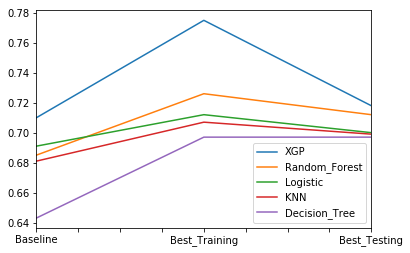

In [128]:
evaluation = lines.plot.line()

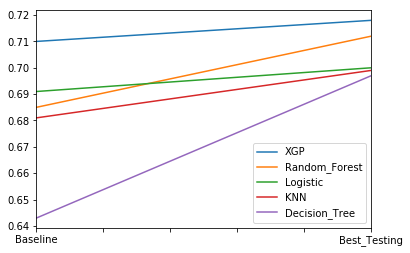

In [133]:
new_lines = comparison_testing.transpose()
evaluation2 = new_lines.plot.line()

## Final Model